In [1]:
from Bio import SeqIO
import numpy as np
from matplotlib import collections as mc
import matplotlib.pyplot as plt
from Bio.Blast.Applications import NcbiblastnCommandline
import pandas as pd
from io import StringIO
import matplotlib.ticker as mtick

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [3]:
#This tool will make a dot/line plot to turn a BLAST alignment result into a visually appealing plot.

#This tool essentially does the work of D-GENIES, but on a smaller scale. D-GENIES works well for whole-genome
#alignments but fails for smaller alignments on the order of kilobases.

#AlignmentPlotter is useful for visually representing local genome editing events but may have other uses for
#clarifying BLAST results.

#The way it works is you have one reference/query sequence and one or more subject sequences. Subjects are aligned
#to the query and are then plotted in separate subplots to show distinctly which regions of each subject mapped
#to which regions of the query and in which orientation.

#The two inputs are FASTA files containing the query and subjects, respectively. Make sure all the sequences
#have unique names.

In [204]:
#For NPY1-GFP #43
#query_fn = 'contig_258_chunk_RC.fa'
#subject_fn = 'NPY1_GFP_Query.fa'

#For YUC1-GFP #41
query_fn = 'contig_20_chunk.fa'
subject_fn = 'YUC1_GFP_Query.fa'

#Don't bother with alignments shorter than this many bp
alignment_cutoff = 400

#Get the lengths of all the different queries and subjects.
length_dict = {}
qrecords = SeqIO.parse(query_fn, "fasta")
for q in qrecords:
    length_dict[q.name] = len(q.seq)
    
srecords = SeqIO.parse(subject_fn, "fasta")
for s in srecords:
    length_dict[s.name] = len(s.seq)


In [205]:
print(length_dict)

{'contig_20_chunk': 21000, 'Donor': 1992, 'Cargo': 720, 'T-DNA': 11611, 'Vector': 6254, 'YUC1_genomic': 6200}


In [206]:
#BLAST your subjects against the query
blast_cline = NcbiblastnCommandline(query=query_fn,subject=subject_fn, evalue=0.05, task='megablast', outfmt='10 qseqid sseqid qstart qend sstart send length')
blast_result = pd.read_csv(StringIO(blast_cline()[0]), header=None)
print(blast_result)

                  0             1      2      3      4     5      6
0   contig_20_chunk         T-DNA   5403  16746  11602   249  11367
1   contig_20_chunk         T-DNA   4086   5399    273  1585   1316
2   contig_20_chunk         T-DNA   7227   7551  10103  9778    327
3   contig_20_chunk         T-DNA   6897   7227   9778  9451    333
4   contig_20_chunk         T-DNA   4969   5352    582   965    389
5   contig_20_chunk         T-DNA  15457  15840    965   582    389
6   contig_20_chunk         T-DNA  16030  16413   1538  1155    386
7   contig_20_chunk         T-DNA   4395   4779   1155  1538    387
8   contig_20_chunk  YUC1_genomic  18091  21000   3025  5933   2910
9   contig_20_chunk  YUC1_genomic      1   2657    380  3036   2657
10  contig_20_chunk  YUC1_genomic   3409   4066   3025  3682    658
11  contig_20_chunk  YUC1_genomic  16759  17339   2456  3036    581
12  contig_20_chunk         Donor  16759  18750      1  1992   1992
13  contig_20_chunk         Donor   2077   4066 

In [207]:
#Everything here involving 'Cargo' is a special bit I needed to include to get an extra line I wanted in my plots
subjects = list(set(blast_result.iloc[:,1]))
if 'Cargo' in subjects:
    subjects.remove('Cargo')
lines = [[]for x in range(len(subjects))]
extra_lines = []

#Get the information from our BLAST results file.
for idx in blast_result.index:
    qname = blast_result.loc[idx,0]
    sname = blast_result.loc[idx,1]
    qstart = blast_result.loc[idx,2]
    qend = blast_result.loc[idx,3]
    sstart = blast_result.loc[idx,4]
    send = blast_result.loc[idx,5]
    length = blast_result.loc[idx,6]
    
    #If the alignment was long enough, we create a line to represent the alignment.
    if (sname != 'Cargo') and (length > alignment_cutoff):
        sub_idx = subjects.index(sname)
        
        lines[sub_idx].append([(qstart, sstart), (qend, send)])
        
    if sname == 'Cargo':
        donor_idx = subjects.index('Donor')
        
        #cargo_offset = 591 #for NPY1-GFP
        cargo_offset =  612 #for YUC1-GFP
        extra_lines.append([(qstart, sstart+cargo_offset), (qend, send+cargo_offset)])
        

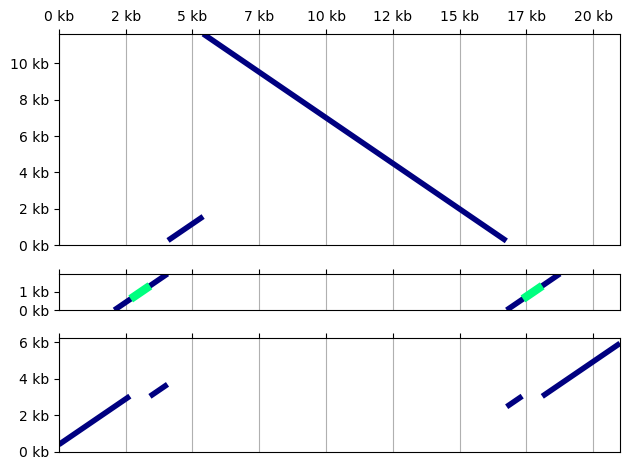

In [208]:
#We want the plots to be "to scale" so the ratios between the subject lengths and query lengths is needed.
height_ratio_list = []
for subject in subjects:
    height_ratio_list.append(length_dict[subject])

#Make the plots
fig,ax = plt.subplots(len(subjects),1, sharex='all', height_ratios=height_ratio_list)
fig.subplots_adjust(hspace=0)
plt.xlim((0, length_dict[qname]))

#Add the lines for each subject alignment in their respective subplots
for idx,subject in enumerate(subjects):
    lc = mc.LineCollection(lines[idx], linewidths=4, color='navy')
    ax[idx].add_collection(lc)
    ax[idx].set_ylim((0, length_dict[subject]))
    
    
    ax[idx].yaxis.set_major_formatter(lambda x, pos: str(int(x/1000))+' kb')
    ax[idx].xaxis.set_major_formatter(lambda x, pos: str(int(x/1000))+' kb')
    #ax[idx].set_xticks([])
    
    ax[idx].tick_params(top=True, labeltop=False, bottom=False, labelbottom=False)
    ax[idx].grid(axis='x')
    
    #This is for the extra green line I needed for my plots
    if subject == 'Donor':
        lc = mc.LineCollection(extra_lines, linewidths=6, color='springgreen')
        ax[idx].add_collection(lc)
        ax[idx].set_ylim((0, length_dict[subject]))


ax[0].tick_params(top=True, labeltop=True, bottom=False, labelbottom=False)

plt.tight_layout()

#Subject labels on the right side would be nice...